<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 4: Snack-O-Meter: a tool to inform consumers on consumption of biscuits

# Content Page

1. [Webscraping for data](01_webscraping.ipynb)
2. [Data cleaning](02_cleaning.ipynb)
3. [EDA](03_eda.ipynb)
4. [Data Modelling](04_modelling.ipynb)

### Modelling

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

import pickle

import time

In [2]:
df = pd.read_csv("../data/final_df.csv")

In [3]:
df.head()

,type,product,per_serving_g,total_fat_g,sugars_g,sodium_g,total_fat_g_per_gram_of_serving,sugars_g_per_gram_of_serving,sodium_g_per_gram_of_serving
0,cookie,Beryl's Chocolate Orange Cashew Nuts Cookies,25.0,4.6,7.6,0.0,0.184,0.304,0.0
1,cookie,Beryl's Coconut Sable with Macadamia Nuts,25.0,9.9,5.1,0.0,0.396,0.204,0.0
2,cookie,Beryl's Cookies Chocolate Sable,25.0,7.2,9.2,0.0,0.288,0.368,0.0
3,cookie,Beryl's Strawberry Sable,25.0,9.4,4.8,0.0,0.376,0.192,0.0
4,cookie,Beryl's Cookies Exquisite Selection (Tin),25.0,4.0,5.0,0.0,0.160,0.200,0.0


In [4]:
df[['total_fat_g_per_gram_of_serving','sugars_g_per_gram_of_serving','sodium_g_per_gram_of_serving']].describe()

,total_fat_g_per_gram_of_serving,sugars_g_per_gram_of_serving,sodium_g_per_gram_of_serving
count,88.000000,88.000000,88.000000
mean,0.235590,0.230701,0.003191
std,0.066612,0.121566,0.001977
min,0.041667,0.000000,0.000000
25%,0.200000,0.147250,0.001862
50%,0.240588,0.252389,0.003225
75%,0.269423,0.325353,0.004465
max,0.405000,0.510000,0.008269


Based on the nutrient guidelines from HPB which can be found [here](https://www.hpb.gov.sg/docs/default-source/newsroom/hcs-nutrient-guidelines-revised-april-2020v2.pdf), there are some references on the guidelines for fat, sugar and sodium content for snacks. 

![image info](../images/HPB_guidelines.png)
![image info](../images/HPB_guidelines_1.png)

Comparing it with the descriptive statistics of the key nutrients of the data we have, we can see that at 50th percentile, fat is 0.245588g/g of serving, sugar is 0.2g/g of serving, sodium is 0.002806g/g of serving. 

The figures for fat and sugar are close to HPB's guidelines and 2024's target (i.e., 0.25 g/g of serving for fat and target of 0.21g/g of serving for sugar in 2024). On the other hand, sodium has a higher threshold based on HPB's guidelines (i.e., 0.0042 g/g of serving) compared to the 50th percentile of our data (i.e., 0.002806 g/g of serving).


We will refer to the recommendations from HPB for fat and sugar content, and refer to the 50th percentile value of sodium from our data to determine if the snack is healthy or not. 

In [5]:
# Based on the above information, we create a function to help us determine the healthiness of the snacks.
def classify_snack(dataframe):
    condition = (
        (dataframe['total_fat_g_per_gram_of_serving'] > 0.25) | 
        ((dataframe['sugars_g_per_gram_of_serving'] > 0.21) &
        (dataframe['sodium_g_per_gram_of_serving'] > 0.002806))
    )
    dataframe['class'] = 1  # 1 means healthy, assign all as healthy first
    dataframe.loc[condition, 'class'] = 0  # 0 means unhealthy

# Call the function to classify snacks
classify_snack(df)

In [6]:
df.groupby("class")['class'].count()

class
0    52
1    36
Name: class, dtype: int64

Based on the count of healthy and unhealthy snacks, we have an imbalanced class and will need to apply techniques to upsample the smaller class 0. 

In [7]:
df.head()

,type,product,per_serving_g,total_fat_g,sugars_g,sodium_g,total_fat_g_per_gram_of_serving,sugars_g_per_gram_of_serving,sodium_g_per_gram_of_serving,class
0,cookie,Beryl's Chocolate Orange Cashew Nuts Cookies,25.0,4.6,7.6,0.0,0.184,0.304,0.0,1
1,cookie,Beryl's Coconut Sable with Macadamia Nuts,25.0,9.9,5.1,0.0,0.396,0.204,0.0,0
2,cookie,Beryl's Cookies Chocolate Sable,25.0,7.2,9.2,0.0,0.288,0.368,0.0,0
3,cookie,Beryl's Strawberry Sable,25.0,9.4,4.8,0.0,0.376,0.192,0.0,0
4,cookie,Beryl's Cookies Exquisite Selection (Tin),25.0,4.0,5.0,0.0,0.160,0.200,0.0,1


In [8]:
# We will use the following columns to build the classifier model
new_df = df[['total_fat_g_per_gram_of_serving','sugars_g_per_gram_of_serving','sodium_g_per_gram_of_serving','class']]

In [9]:
# We can see that different snacks are classified to class 0 or 1. 
new_df.sample(10)

,total_fat_g_per_gram_of_serving,sugars_g_per_gram_of_serving,sodium_g_per_gram_of_serving,class
40,0.230769,0.192308,0.004038,1
47,0.219444,0.333333,0.002778,1
57,0.260000,0.340000,0.003250,0
5,0.214286,0.303571,0.003500,0
46,0.275000,0.350000,0.005083,0
20,0.277000,0.300000,0.003070,0
6,0.210714,0.303571,0.003357,0
54,0.266667,0.166667,0.002500,0
19,0.174074,0.333333,0.004526,0
79,0.405000,0.160000,0.003925,0


In [10]:
X = new_df.drop(['class'], axis=1)
y = new_df['class']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42) 

In [12]:
#We apply SMOTE on the training data to ensure there is a balanced class for the classification. 
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [13]:

pipelines = []
pipelines.append(('LogisticRegression' ,LogisticRegression()))
pipelines.append(('DecisionTree' ,DecisionTreeClassifier()))
pipelines.append(('RandomForest',RandomForestClassifier()))
pipelines.append(('BaggingDecisionTree',BaggingClassifier()))

model_name = []
train_acc_results = []
test_acc_results = []
train_cv_acc_results = []
time_data = []


for pipe, model in pipelines:
    
    tic = time.time()
    
    model_created = model.fit(X_train_resampled,y_train_resampled)
    train_acc_results.append(accuracy_score(y_train_resampled,model.predict(X_train_resampled)))
    test_acc_results.append(accuracy_score(y_test,model.predict(X_test)))
    model_name.append(pipe)
    
    crossv_results = cross_val_score(model , X_train_resampled ,y_train_resampled ,cv =5 , scoring='accuracy')
    
    train_cv_acc_results.append(crossv_results.mean())
    
    toc = time.time()
    
    time_taken = toc - tic 
    
    time_data.append(time_taken)
    
    
    msg = model
    msg_1 = "Train classification report"
    msg_2 = "Test classification report"
    msg_3 = "%s -> cross_val_score for train accuracy using cv=5: %f" % (model, crossv_results.mean())
    
    print(msg)
    print(msg_1)
    print(classification_report(y_train_resampled, model_created.predict(X_train_resampled)))
    print(msg)
    print(msg_2)
    print(classification_report(y_test, model_created.predict(X_test)))
    print(msg_3)
    print(f"Time taken is {time_taken} seconds")
    print("========================================================================")
    

LogisticRegression()
Train classification report
              precision    recall  f1-score   support

           0       0.76      0.78      0.77        37
           1       0.78      0.76      0.77        37

    accuracy                           0.77        74
   macro avg       0.77      0.77      0.77        74
weighted avg       0.77      0.77      0.77        74

LogisticRegression()
Test classification report
              precision    recall  f1-score   support

           0       0.93      0.87      0.90        15
           1       0.75      0.86      0.80         7

    accuracy                           0.86        22
   macro avg       0.84      0.86      0.85        22
weighted avg       0.87      0.86      0.87        22

LogisticRegression() -> cross_val_score for train accuracy using cv=5: 0.664762
Time taken is 0.06356573104858398 seconds
DecisionTreeClassifier()
Train classification report
              precision    recall  f1-score   support

           0       

In [14]:
all_models = list(zip(model_name,train_acc_results,test_acc_results,train_cv_acc_results,time_data))

models_df = pd.DataFrame(all_models).rename(columns={0:"Model",1:"Train_accuracy_score",2: 'Test_accuracy_score',3:"Train_crossval_accuracy_score",4:"Time_taken_to_complete (in secs)"})

In [15]:
models_df

,Model,Train_accuracy_score,Test_accuracy_score,Train_crossval_accuracy_score,Time_taken_to_complete (in secs)
0,LogisticRegression,0.77027,0.863636,0.664762,0.063566
1,DecisionTree,1.00000,1.000000,0.946667,0.034819
2,RandomForest,1.00000,1.000000,0.933333,1.525122
3,BaggingDecisionTree,1.00000,1.000000,0.920000,0.220255


Based on the various metrics in the dataframe above, we can see that Decision Tree provides the best performance and runs with the least amount of time. 
We will deploy the Decision Tree model in our snack-o-meter app.

In [16]:
# We will now pickle out the Decision Tree model for deployment. 
DT = DecisionTreeClassifier()
DT = DT.fit(X_train_resampled,y_train_resampled)
pickle.dump(DT,open("../streamlit/classifier.pkl","wb"))

[Text(0.6, 0.875, 'x[0] <= 0.253\ngini = 0.5\nsamples = 74\nvalue = [37, 37]'),
 Text(0.4, 0.625, 'x[1] <= 0.232\ngini = 0.292\nsamples = 45\nvalue = [8, 37]'),
 Text(0.2, 0.375, 'gini = 0.0\nsamples = 23\nvalue = [0, 23]'),
 Text(0.6, 0.375, 'x[2] <= 0.003\ngini = 0.463\nsamples = 22\nvalue = [8, 14]'),
 Text(0.4, 0.125, 'gini = 0.0\nsamples = 14\nvalue = [0, 14]'),
 Text(0.8, 0.125, 'gini = 0.0\nsamples = 8\nvalue = [8, 0]'),
 Text(0.8, 0.625, 'gini = 0.0\nsamples = 29\nvalue = [29, 0]')]

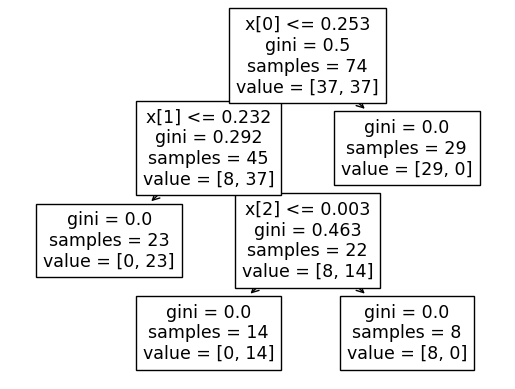

In [36]:
# Plotting the decision tree that we have built for deployment.
from sklearn import tree
tree.plot_tree(DT)

From the decision tree, x[0] refers to the fat content, x[1] refers to the sugar content and x[3] refers to the sodium content. 
We can see that it has learned the criteria that we have determined earlier to classify the biscuits.
In addition, the fat content was the most influential variable for the decision tree in making the initial split.

### Conclusion

- Our decision tree model yields train and test accuracy greater than 0.9, and the train cross validation score also shows that the model is reliable to be deployed for classification.
- With this model, we developed an user-friendly tool (https://snack-o-meter.streamlit.app/) to help consumers identify if the biscuit of their choice is healthy or not, and recommend healthy alternatives.


### Recommendations

1 - **Increase Public Awareness**

- Through marketing campaigns (offline and online campaigns)

2 - **Expand the model to include other snack types**

- For example: Nuts and chips

3 - **Integrate tool into HPB’s existing Health 365 app**

- Intergration is beneficial as it makes Health 365 as “one stop app”


### Cost Benefit Analysis

**Estimated Cost (per year): $500,000**

**1. Marketing Campaign for "Snack-O-Meter": $400,000** 

The Nutri-Grade mark was officially launched on 30 Dec 2022. In FY2022, HPB spent $400,000 on programme, supplies & marketing. Using this as a reference, it is expected that the marketing campaign for "Snack-O-Meter" will cost about the same.

_Sources:_ 
- _HPB Annual Report 2021/2022: https://www.hpb.gov.sg/docs/default-source/pdf/hpb-2022_2023-annual-report.pdf?sfvrsn=bec1a971_2_ 
- _MOH News Highlight: https://www.moh.gov.sg/news-highlights/details/rollout-of-nutri-grade-mark-on-30-december-2022_

**2. Application Development and Maintenance: $100,000** 

The intention is for the "Snack-O-Meter" to be incorporated into HPB's existing application, the Health 365. The advantage of integration (as opposed to building a standalone app) is that it would save cost on app development. In addition, it also uses the Health 365 as a "one-stop" app for the public with regards to health matters. Lastly, there would be no additional server cost required.

_Source:_ 
- _How Much Does It Cost to Develop an App in Singapore in 2022?: https://neetable.com/blog/app-development-cost-in-singapore_


**Estimated Benefit (per year): $12,840,000**


**3.  Healthcare cost of metabolic risk: $642,000,000** 

Research conducted in 2023 calculated that the healthcare cost arising from metabolic risks would amounted to S$642 million. Metabolic risk in this study is defined by high systolic blood pressure, high fasting plasma glucose, high LDL cholesterol. Consumption of sodium, sugar, and fat are positively correlated to the above metabolic risk.

From FY2017 to FY2019, the median sugar level of beverages decreased from 8.5 to 6.3 grams per 100 ml (25%). This was attributed to the Nutri-Grade campaign which led to suppliers reducing sugar in their beverages.

According to Etiqa's Nutrition Survey conducted in 2022, most snackers would snack more than 3 times in a week. Assuming a person consumed a serving of Hello Panda Chocolate a day, that would constitute about 8% of the daily average fats, sodium and sugar intake overall in Singapore. If the sucess of the Nutri-Grade campaign (25% reduction) can be applied to "Snack-O-Meter", a 2% (25% * 8%) reduction in daily intake of fats, sodium, and sugar intake is expected. Lastly, assuming that reduction in consumption of those nutrients of concern can directly impact metabolic risk by the same %, then a reduction of healthcare cost of $12,840,000 is expected.

_Sources:_
- _The societal cost of modifiable risk factors in Singapore: https://bmcpublichealth.biomedcentral.com/articles/10.1186/s12889-023-16198-2_ 
- _Ministry of Health’s (MOH) National Population Health Survey (NPHS) 2022 and Health Promotion Board’s (HPB) National Nutrition Survey (NNS) 2022: https://www.moh.gov.sg/news-highlights/details/national-health-surveys-highlight-need-to-focus-on-healthy-diets-and-lifestyles_


### Extra component: Trying K-means clustering to label data for modelling

In the above modelling, we made use of rule-based data labelling and model performance was good. We want to further explore if adopting unsupervised learning such as K-means clustering to assign the labels would improve model performance. 

In [17]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.preprocessing import StandardScaler

In [18]:
df_clustering = new_df[['total_fat_g_per_gram_of_serving','sugars_g_per_gram_of_serving','sodium_g_per_gram_of_serving']]

In [19]:
scaler = StandardScaler().fit(df_clustering)
scaled_df = scaler.transform(df_clustering)

In [20]:
df_clustering_features = df_clustering.columns
df_clustering_features

Index(['total_fat_g_per_gram_of_serving', 'sugars_g_per_gram_of_serving',
       'sodium_g_per_gram_of_serving'],
      dtype='object')

/Users/licheng/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/licheng/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/licheng/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/licheng/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/liche

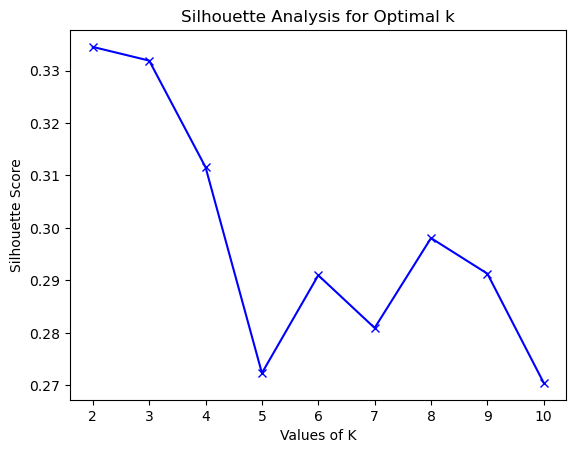

In [21]:
# We can use Silhouette scores to find the best K value.
range_n_clusters = [2, 3, 4, 5, 6, 7, 8,9,10]
silhouette_scores = []
for num_clusters in range_n_clusters:
 
    # instantiate and fit kmeans model for each k value
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(scaled_df)
    cluster_labels = kmeans.labels_
 
    # generate silhouette score
    silhouette_scores.append(silhouette_score(scaled_df, cluster_labels))
    
plt.plot(range_n_clusters, silhouette_scores, 'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette Score') 
plt.title('Silhouette Analysis for Optimal k')
plt.show()

# Silhouette score : choose the highest score.

Based on the above Silhouette analysis chart, k = 2 yields the highest score. 

/Users/licheng/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/licheng/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/licheng/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/licheng/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/liche

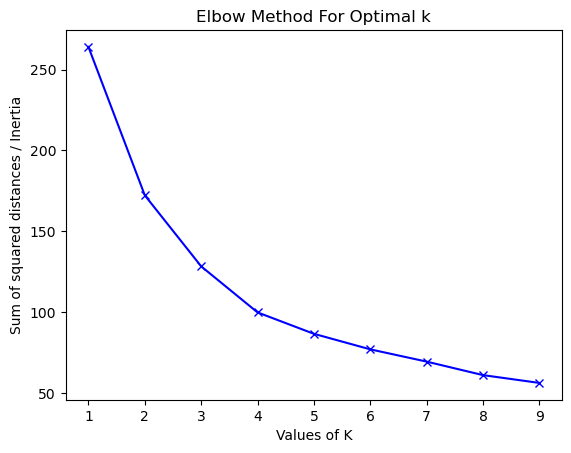

In [22]:
# We try to plot the chart using the inertia to determine the best k value. 

sum_of_squared_distances = []
K = range(1,10)

for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(scaled_df)
    
    # Inertia tells how far away the points within a cluster are. Therefore, a small of inertia is aimed for
    # Inertia can range from zero to infinity
    sum_of_squared_distances.append(kmeans.inertia_)
    
plt.plot(K,sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances / Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()


Based on the chart above, the steepest gradient happened at k=2, this shows that we should try to cluster the data into 2 groups.

In [23]:
# Instantiate a clustering object with 2 clusters
clustering = KMeans(n_clusters=2, max_iter=500, random_state=42)

clustering.fit(scaled_df)

/Users/licheng/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(max_iter=500, n_clusters=2, random_state=42)

In [24]:
classes = clustering.labels_
scaled_dataset = pd.DataFrame(np.hstack((scaled_df, classes.reshape(-1, 1))))
scaled_dataset = scaled_dataset.rename(columns={0:"total_fat",1:"sugars",2:"sodium",3:"class"})
scaled_dataset.groupby('class')['class'].count()

class
0.0    30
1.0    58
Name: class, dtype: int64

With the clustering method, the classes are imbalanced,  which will require us to run techniques like SMOTE to upsample class 0.

Text(0.5, 1.0, 'K-means clustering')

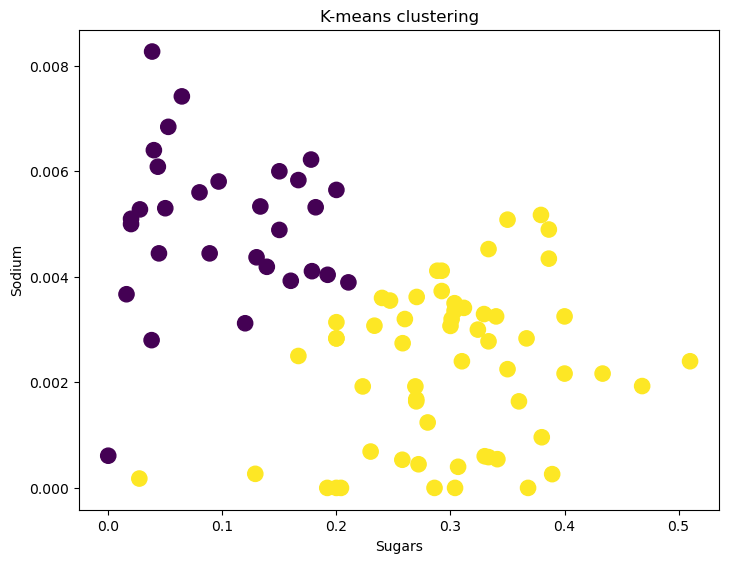

In [25]:
# create visualisation of clustering results
fig = plt.figure()
ax = fig.add_axes([.1, .1, 1, 1])

# set colours to represent respective model labels
colors = clustering.labels_

#unscaled the data for visualisation
df_unscaled = scaler.inverse_transform(scaled_df)

# display scatter plot at column index = 2 and column index = 1
# c refers to label colours which equal to model labels in this case
# s refers to the size of the scatter plot
ax.scatter(df_unscaled[:,1], df_unscaled[:,2], c=colors, s=120)


# set labels for axes
ax.set_xlabel('Sugars')
ax.set_ylabel('Sodium')

# set title fror scatter plot
plt.title('K-means clustering')

By plotting sodium against sugars, we can see two distinct clusters separated by a linear line (i.e. y = mx + c).

Text(0.5, 1.0, 'K-means clustering')

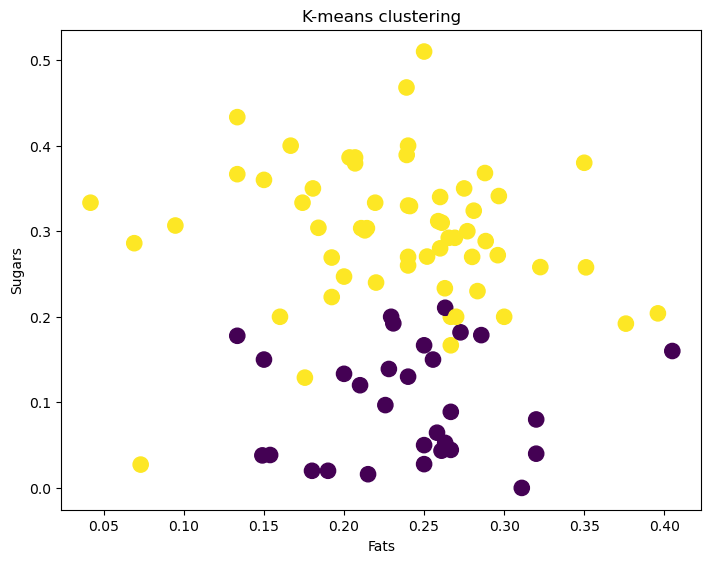

In [26]:
# create visualisation of clustering results
fig = plt.figure()
ax = fig.add_axes([.1, .1, 1, 1])

# set colours to represent respective model labels
colors = clustering.labels_

#unscaled the data for visualisation
df_unscaled = scaler.inverse_transform(scaled_df)

# display scatter plot at column index = 2 and column index = 1
# c refers to label colours which equal to model labels in this case
# s refers to the size of the scatter plot
ax.scatter(df_unscaled[:,0], df_unscaled[:,1], c=colors, s=120)


# set labels for axes
ax.set_xlabel('Fats')
ax.set_ylabel('Sugars')

# set title fror scatter plot
plt.title('K-means clustering')

By plotting sugars against fats, we can see two clusters with slight overlap generally separated by a horizontal line of y = c. 

Text(0.5, 1.0, 'K-means clustering')

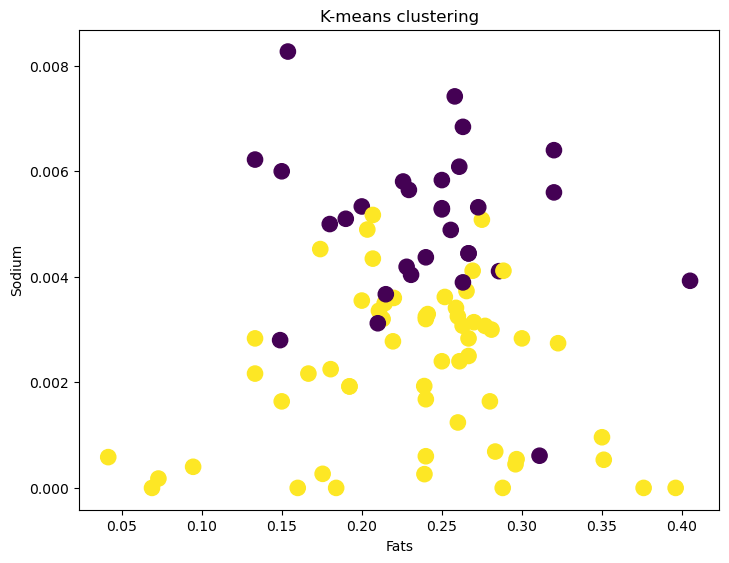

In [27]:
# create visualisation of clustering results
fig = plt.figure()
ax = fig.add_axes([.1, .1, 1, 1])

# set colours to represent respective model labels
colors = clustering.labels_

#unscaled the data for visualisation
df_unscaled = scaler.inverse_transform(scaled_df)

# display scatter plot at column index = 2 and column index = 1
# c refers to label colours which equal to model labels in this case
# s refers to the size of the scatter plot
ax.scatter(df_unscaled[:,0], df_unscaled[:,2], c=colors, s=120)


# set labels for axes
ax.set_xlabel('Fats')
ax.set_ylabel('Sodium')

# set title fror scatter plot
plt.title('K-means clustering')

By plotting sodium against fats, there is more overlap in the data points when determining the clusters. This suggests that the k-means clustering is not quite able to distinctively differentiate the data points.

In [28]:
X_cluster = scaled_dataset.drop(['class'],axis = 1)
y_cluster = scaled_dataset['class']

In [29]:
Xc_train, Xc_test, yc_train, yc_test = train_test_split(X_cluster, y_cluster, test_size = 0.25, random_state = 42) 

In [30]:
smote = SMOTE(random_state=42)
Xc_train_resampled, yc_train_resampled = smote.fit_resample(Xc_train, yc_train)

In [31]:

pipelines = []
pipelines.append(('LogisticRegression' ,LogisticRegression()))
pipelines.append(('DecisionTree' ,DecisionTreeClassifier()))
pipelines.append(('RandomForest',RandomForestClassifier()))
pipelines.append(('BaggingDecisionTree',BaggingClassifier()))

model_name = []
train_acc_results = []
test_acc_results = []
train_cv_acc_results = []
time_data = []


for pipe, model in pipelines:
    
    tic = time.time()
    
    model_created = model.fit(Xc_train_resampled,yc_train_resampled)
    train_acc_results.append(accuracy_score(yc_train_resampled,model.predict(Xc_train_resampled)))
    test_acc_results.append(accuracy_score(yc_test,model.predict(Xc_test)))
    model_name.append(pipe)
    
    crossv_results = cross_val_score(model , Xc_train_resampled ,yc_train_resampled ,cv =5 , scoring='accuracy')
    
    train_cv_acc_results.append(crossv_results.mean())
    
    toc = time.time()
    
    time_taken = toc - tic 
    
    time_data.append(time_taken)
    
    
    msg = model
    msg_1 = "Train classification report"
    msg_2 = "Test classification report"
    msg_3 = "%s -> cross_val_score for train accuracy using cv=5: %f" % (model, crossv_results.mean())
    
    print(msg)
    print(msg_1)
    print(classification_report(yc_train_resampled, model_created.predict(Xc_train_resampled)))
    print(msg)
    print(msg_2)
    print(classification_report(yc_test, model_created.predict(Xc_test)))
    print(msg_3)
    print(f"Time taken is {time_taken} seconds")
    print("========================================================================")
    

LogisticRegression()
Train classification report
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        42
         1.0       1.00      1.00      1.00        42

    accuracy                           1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg       1.00      1.00      1.00        84

LogisticRegression()
Test classification report
              precision    recall  f1-score   support

         0.0       0.86      1.00      0.92         6
         1.0       1.00      0.94      0.97        16

    accuracy                           0.95        22
   macro avg       0.93      0.97      0.95        22
weighted avg       0.96      0.95      0.96        22

LogisticRegression() -> cross_val_score for train accuracy using cv=5: 0.988235
Time taken is 0.051586151123046875 seconds
DecisionTreeClassifier()
Train classification report
              precision    recall  f1-score   support

         0.0      

In [32]:
all_models_cluster = list(zip(model_name,train_acc_results,test_acc_results,train_cv_acc_results,time_data))

models_df_cluster = pd.DataFrame(all_models_cluster).rename(columns={0:"Model",1:"Train_accuracy_score",2: 'Test_accuracy_score',3:"Train_crossval_accuracy_score",4:"Time_taken_to_complete (in secs)"})

In [33]:
# Performance of using unsupervised learning for the labelling
models_df_cluster

,Model,Train_accuracy_score,Test_accuracy_score,Train_crossval_accuracy_score,Time_taken_to_complete (in secs)
0,LogisticRegression,1.0,0.954545,0.988235,0.051586
1,DecisionTree,1.0,0.909091,0.964706,0.023965
2,RandomForest,1.0,0.909091,1.000000,0.959055
3,BaggingDecisionTree,1.0,0.909091,0.964706,0.140025


Based on the model performance of adopting unsupervised learning in assigning the labels, we can see that the models perform decently with most metrics exceeding 0.9.

In [34]:
# Performance of using rule-based manual labelling
models_df

,Model,Train_accuracy_score,Test_accuracy_score,Train_crossval_accuracy_score,Time_taken_to_complete (in secs)
0,LogisticRegression,0.77027,0.863636,0.664762,0.063566
1,DecisionTree,1.00000,1.000000,0.946667,0.034819
2,RandomForest,1.00000,1.000000,0.933333,1.525122
3,BaggingDecisionTree,1.00000,1.000000,0.920000,0.220255


Based on the model performance, rule-based manual labelling performs better on unseen data based on the test accuracy scores.